## Rapidly exploring random trees

![](imgs/RRT.png)

![](imgs/RRT-vis.png)

In [1]:
!pip install requests ipympl

In [2]:
import requests
import os
def wget(url, filename):
    r = requests.get(url)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content():
            fd.write(chunk)
url = 'https://vikasdhiman.info/ECE498-Mobile-Robots/notebooks/01-1901-discrete-planning/imgs/RRT-map.png'
filename = 'imgs/RRT-map.png'
wget(url, filename)

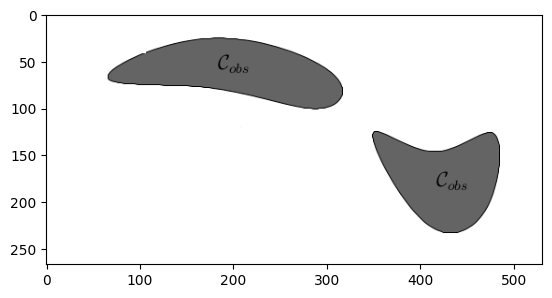

In [3]:
%matplotlib inline
import numpy as np
import random
random.seed(1004)
np.random.seed(1004)
from PIL import Image
import matplotlib.pyplot as plt
# I removed the graph lines from the map above using photoshop and 
# saved only the obstacles. Load that map as a png file.
# It is color image; convert it to grayscale.
img_gray = Image.open("imgs/RRT-map.png").convert('L')
# convert the image to a numpy array
img = np.asarray(img_gray)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') # plot the image

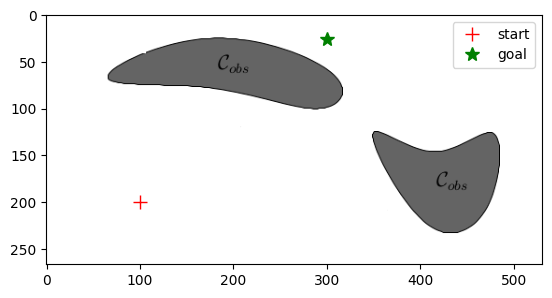

In [4]:
%matplotlib inline
# Pick some arbitray start and goal points
goal = (300., 25.)
start = (100., 200.)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') # Plot the image again
ax.plot(start[0], start[1], 'r+', markersize=10, label='start') 
ax.plot(goal[0], goal[1], 'g*', markersize=10, label='goal')
ax.legend()

## We have a problem to solve
We want to find the shortest path from start to goal in the continuous domain while avoiding obstacles.

### Rapidly exploring random trees

The main idea of the algorithm is:
1. Initialize an empty graph with the start point
2. While not done:
   
    a. Sample points on the chosen area. If the point is obstacle area, continue to the next iteration.
   
    b. Connect the sampled point to the nearest point (vertex or edge) on the graph, as long as the connecting line does not pass through the obstacle.

In [5]:
from dataclasses import dataclass
# Need img as the map representation
assert img is not None

# https://docs.python.org/3/library/queue.html#queue.PriorityQueue
@dataclass
class Vertex:
    idx: int
    coord: np.ndarray

    # Make the PItem hashable
    # https://docs.python.org/3/glossary.html#term-hashable
    def __hash__(self):
        return self.idx

class Graph:
    """
    Keeps track of nodes and their 2D coordinates. 
    The datastructure of choice here is an adjacency list.
    """
    def __init__(self):
        self.adjacency_list = {}
        self.vertex_list = []

    @classmethod
    def from_adjacency_matrix(cls, vertex_coords, G_adjacency_matrix):
        self = cls()
        self.vertex_coordinates = vertex_coords
        for vi, v in enumerate(vertex_coords):
            vert = Vertex(idx=vi, coord=v)
            self.vertex_list.append(vert)
            self.adjacency_list[vert] = [
                Vertex(idx=pnj, coord=pn)
                for pnj, pn in enumerate(vertex_coords)
                if (G_adjacency_matrix[vi, pnj])]
        return self

    def get(self, v, default=[]):
        return self.adjacency_list[v]

    def add_vertex(self, coordinate):
        idx = len(self.vertex_list)
        vert = Vertex(idx=idx, coord=coordinate)
        self.adjacency_list[vert] = []
        self.vertex_list.append(vert)
        return vert

    def add_edge_directed(self, vi, vj):
        assert isinstance(vi, Vertex)
        assert isinstance(vj, Vertex)
        self.adjacency_list.setdefault(vi, []).append(vj)
        
    def add_edge(self, vi, vj, undirected=True):
        self.add_edge_directed(vi, vj)
        if undirected:
            self.add_edge_directed(vj, vi)

    def vertices(self):
        return self.adjacency_list.keys()

    def get_vertex(self, idx):
        return self.vertex_list[idx]

    def vertex_coords(self):
        return np.asarray([vert.coord
                           for vert in self.adjacency_list.keys()])

    def vertices_no_nbrs(self):
        return [vid for vid, nbrsid in self.adjacency_list.items() if not len(nbrsid)]
        
    def edges_coords(self):
        edge_ids = []
        edge_list = []
        for vid, nbrsid in self.adjacency_list.items():
            for nid in nbrsid:
                edge_ids.append((vid.idx, nid.idx))
                edge_list.append((vid.coord, nid.coord))
        return edge_ids, edge_list

    def plot(self, ax, vertexids=False):
        ax.axis('equal')
        edge_ids, edge_coords = self.edges_coords()
        for (vid, nid), (v, n) in zip(edge_ids, edge_coords):
            ax.plot([v[0], n[0]], [v[1], n[1]], 'k-')
            if vertexids:
                ax.text(v[0], v[1], str(vid))
                ax.text(n[0], n[1], str(nid))

# 1. Initialize an empty graph with the start point
G_adjacency_list = Graph()
G_adjacency_list.add_vertex(start)
        
Npts = 1 # we are going to sample 100 points, but start with 1 point
pt_min, pt_max = np.array([0, 0]), np.array([img.shape[1], img.shape[0]])
# 2. While not done:
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    # If the point is obstacle area, continue to the next iteration.
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

random_pt

array([ 20.68332004, 228.68439464])

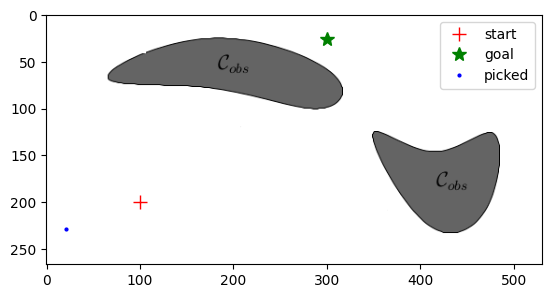

In [6]:
%matplotlib inline
# Let's plot this point
def plot_map(ax, img, goal, start):
    ax.imshow(img, cmap='gray') # Plot the image again
    ax.plot(start[0], start[1], 'r+', markersize=10, label='start') 
    ax.plot(goal[0], goal[1], 'g*', markersize=10, label='goal')
    ax.legend()
    return ax
fig, ax = plt.subplots()
plot_map(ax, img, goal, start)
picked_pt, = ax.plot(random_pt[0], random_pt[1], 'bo', markersize=2, label='picked')
ax.legend()

In [7]:
# check the color of image at the random_pt
# Note that I have used y-coordinate for rows and
# x-coordinate for cols
random_pt_int = np.round(random_pt).astype(dtype=np.int64)
img[random_pt_int[1], random_pt_int[0]]

np.uint8(255)

15

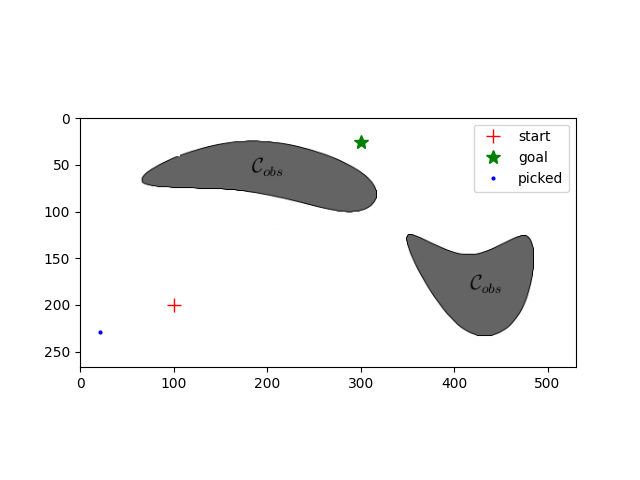

In [8]:
# Click anywere on the gray area in the image to find the color of that point
import ipywidgets as widgets # Make the print statement interactive
# Make the matplotlib figure interactive
%matplotlib widget

# Draw the map
fig, ax = plt.subplots()
plot_map(ax, img, goal, start)
picked_pt, = ax.plot(random_pt[0], random_pt[1], 'bo', markersize=2, label='picked')
ax.legend()

# # Create a textarea to display the interactive message
# txtwidget = widgets.Textarea(
#     value='Picked point has Color: None',
#     placeholder='Picked point has Color: None',
#     description='Clicked at ',
#     disabled=True,
#     width=200
# )
# display(txtwidget)

# This function will be called whenever you click anywhere on the map
def onclick(event):
    x, y = event.xdata, event.ydata
    picked_pt.set_xdata([x])
    picked_pt.set_ydata([y])
    # Change the display message in the figure
    txtwidget.value = "Picked point has Color: %d" % (img[int(y), int(x)])
    
fig.canvas.mpl_connect('button_release_event', onclick)

In [9]:
# Make the figure non-interactive again
%matplotlib inline

In [10]:

# 100 is darker than 255. 
# Our collision check is checking for the color. 
# I pick the threshold between 100 and 255 arbitrarily as 
# 200
def do_points_collide(img, pts):
    # threshold between white (255) and gray (100) color
    threshold = 200
    pts = np.round(pts).astype(dtype=np.int64)
    in_img = ((0 <= pts) & (pts < np.array((img.shape[1], img.shape[0])))).all(axis=-1)
    dummy_pts = pts.copy()
    out_of_img = ~in_img
    dummy_pts[~in_img] = 0
    return (out_of_img) | (img[dummy_pts[..., 1], dummy_pts[..., 0]] < threshold)

def does_point_collide(img, pt):
    return do_points_collide(img, pt)

# Lets check our function again
# For a collision free point
assert does_point_collide(img, np.array([20.68332004, 228.68439464])) == False
# For a collision point
assert does_point_collide(img, np.array([200., 50.])) == True

We are going to go back to our incomplete algorithm and add collision check

In [11]:
# Need img as the map representation
assert img is not None

# 1. Initialize an empty graph with the start point
G_adjacency_list = Graph()
G_adjacency_list.add_vertex(start)

Npts = 1 # we are going to sample 100 points, but start with 1 point
# Specify the bounds of the map
pt_min = np.array([0, 0])
pt_max = np.array([img.shape[1], img.shape[0]])

# 2. While not done
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

    # If the point is obstacle area, continue to the next iteration.
    if does_point_collide(img, random_pt):
        continue

    # 2.B Connect the sampled point to the nearest point (vertex or edge) 
    # on the graph, as long as the connecting line does not pass through the obstacle.

    
    

# Finding the nearest vertex or edge on graph

There are faster algorithms to do this where we can maintain a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) and lookup the nearest vertex in $O(log(|V|))$ time. 

However, we are going to go with brute force approach and loop over all the vertices to find the closest vertex, which is $O(|V|)$.

In [12]:
vertices_np = G_adjacency_list.vertex_coords() # np.array of size N x 2
diff_vec = (vertices_np - random_pt) # np.array of size N x 2
dists_per_vec = np.sqrt((diff_vec**2).sum(axis=-1)) # np.array of size N
closest_vertex = vertices_np[np.argmin(dists_per_vec)] # np.array of size 2
closest_vertex

array([100., 200.])

Let's make the above code a function and stress test it a bit. 

In [13]:
def find_nearest_vertex(G_adjacency_list, pt):
    vertices_np = G_adjacency_list.vertex_coords() # np.array of size N x 2
    diff_vec = (vertices_np - pt) # np.array of size N x 2
    dists_per_vec = np.sqrt((diff_vec**2).sum(axis=-1)) # np.array of size N
    closest_vertex = vertices_np[np.argmin(dists_per_vec)] # np.array of size 2
    return closest_vertex

In [14]:
# Create a random graph to stress test the function
def generate_random_graph(nvertices=10, # How many vertices
                          # Fraction of vertices connected to each other
                          # 1 means fully connected
                          # 0 means none connected
                          edge_density=0.2, 
                          selfedges=False, # allow self edges
                          undirected=True, # is the graph undirected
                          pt_min=np.array([0., 0.]), # range of points
                          pt_max=np.array([1., 1.])):
    D = pt_min.shape[0] # dimensions
    vertices = np.random.rand(nvertices, D) * (pt_max - pt_min) + pt_min
    G_adjacency_matrix_samples = np.random.rand(
        nvertices, nvertices)
    
    if undirected:
        matrix_edge_density = edge_density / 2
        G_adjacency_matrix_samples = np.tril(G_adjacency_matrix_samples, k=1)
        G_adjacency_matrix_samples += G_adjacency_matrix_samples.T
        G_adjacency_matrix_samples /= 2.
    # Pick the edge if the uniformly sampled prob is below edge_density
    G_adjacency_matrix = G_adjacency_matrix_samples < matrix_edge_density
    np.fill_diagonal(G_adjacency_matrix, 0)
    G_adjacency_list = Graph.from_adjacency_matrix(vertices.tolist(), G_adjacency_matrix)
    return G_adjacency_list

generate_random_graph()

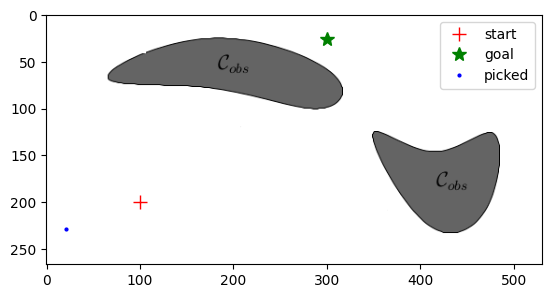

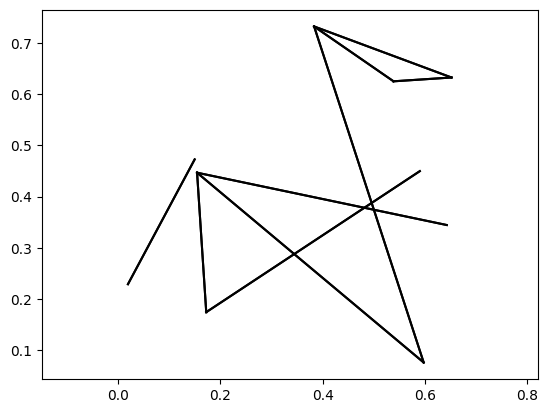

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
graph = generate_random_graph()
graph.plot(ax)

Let's pick a test point near different nodes by click on them and see if we 
get the right nearest vertex.

15

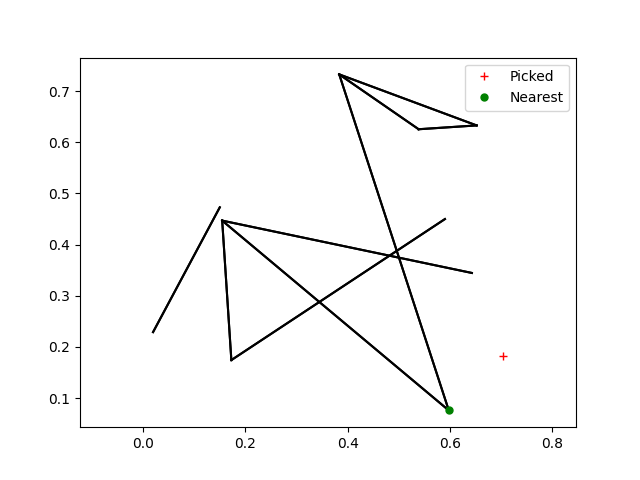

In [16]:
%matplotlib widget
fig, ax = plt.subplots()
graph.plot(ax)
picked_pt = np.random.rand(2) 
nearest_pt = find_nearest_vertex(graph, picked_pt)
pickedline, = ax.plot(picked_pt[0], picked_pt[1], 'r+', label='Picked')
nearestline, = ax.plot(nearest_pt[0], nearest_pt[1], 'go', markersize=5, label='Nearest')
ax.legend()

# useful for debuging
# # Create a textarea to display the interactive message
# txtwidget = widgets.Textarea(
#     value='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     placeholder='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     description='',
#     disabled=True
# )
# display(txtwidget)

def onclick_nearest(event):
    pickedline.set_xdata([event.xdata])
    pickedline.set_ydata([event.ydata])
    
    nearest_pt = find_nearest_vertex(graph, np.array([event.xdata, event.ydata]))
    nearestline.set_xdata(nearest_pt[:1])
    nearestline.set_ydata(nearest_pt[1:])
    # txtwidget.value = f'Picked: ({event.xdata:0.3f}, {event.ydata:0.3f}); Nearest: {nearest_pt}'
    
fig.canvas.mpl_connect('button_release_event', onclick_nearest)    

In [17]:
def closest_point_on_line_segs(edges, pt):
    assert edges.shape[-2] == 2
    *N, _, D = edges.shape
    vs, ve = edges[:, 0, :], edges[:, 1, :]
    edge_vec = ve - vs # *N x D
    edge_mag = np.linalg.norm(edge_vec, axis=-1, keepdims=True) #  *N 
    edge_unit = edge_vec / edge_mag # *N x D
    
    # pt on edge = x = vs + t * edge_unit
    # (x - pt) @ edge_unit = 0
    # ((vs + t * edge_unit) - pt) @ edge_unit = 0
    # t = (pt - vs) @ edge_unit
    t = ((pt - vs) * edge_unit).sum(axis=-1, keepdims=True) # N x 1
    x = vs + t * edge_unit # *N x D
    dist_e = np.linalg.norm(pt - x, axis=-1)
    dist_vs = np.linalg.norm(vs - pt, axis=-1)
    dist_ve = np.linalg.norm(ve - pt, axis=-1)
    is_pt_on_edge = ((0 <= t) & (t <= edge_mag))[..., 0]
    dist_v = np.minimum(dist_vs, dist_ve)
    dist = np.where( is_pt_on_edge,
                    dist_e,
                    dist_v)
    min_idx = np.argmin(dist)
    closest_point, point_type =  (
        (x[min_idx], slice(0, 2)) if is_pt_on_edge[min_idx] 
        else (vs[min_idx], slice(0, 1)) if (dist_vs[min_idx] < dist_ve[min_idx]) 
        else (ve[min_idx], slice(1, 2))
    )
    return closest_point, dist[min_idx], (min_idx, point_type)

15

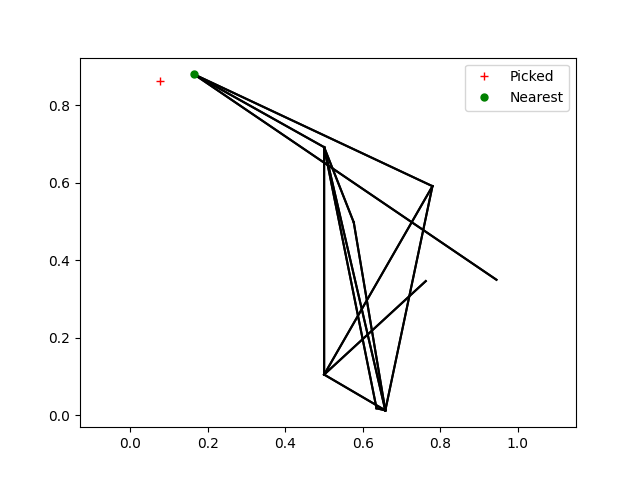

In [18]:
%matplotlib widget
fig, ax = plt.subplots()
graph = generate_random_graph()
graph.plot(ax)
picked_pt =  np.random.rand(2) 
nearest_pt, _, _ = closest_point_on_line_segs(np.asarray(graph.edges_coords()[1]), picked_pt)
pickedline, = ax.plot(picked_pt[0], picked_pt[1], 'r+', label='Picked')
nearestlines, = ax.plot(nearest_pt[0], nearest_pt[1], 'go', markersize=5, label='Nearest')
ax.legend()

# # useful for debuging
# # Create a textarea to display the interactive message
# txtwidget = widgets.Textarea(
#     value='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     placeholder='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     description='',
#     disabled=True
# )
# display(txtwidget)

def onclick_nearest(event):
    pickedline.set_xdata([event.xdata])
    pickedline.set_ydata([event.ydata])
    picked_pt = np.array([event.xdata, event.ydata])
    nearest_pt, _, _ = closest_point_on_line_segs(np.asarray(graph.edges_coords()), picked_pt)
    # txtwidget.value = str(nearest_pt)
    nearestlines.set_xdata([nearest_pt[0]])
    nearestlines.set_ydata([nearest_pt[1]])
    
fig.canvas.mpl_connect('button_release_event', onclick_nearest)    


In [19]:
def closest_point_on_graph(graph, pt):
    assert len(graph.vertices())
    edge_ids, edge_list = map(np.asarray, graph.edges_coords())
    if len(edge_list):
        closest_point_e, min_dist_e, min_idx_pt_type = closest_point_on_line_segs(edge_list, pt)
        min_idx_e, pt_type = min_idx_pt_type
        vids = edge_ids[min_idx_e, pt_type]
        vertices = ((graph.get_vertex(vids[0]), graph.get_vertex(vids[1])) 
                    if len(vids) == 2
                    else
                    (graph.get_vertex(vids[0]),))
    else:
        min_dist_e = np.inf
    
    vertices_no_nbrs = graph.vertices_no_nbrs()
    if len(vertices_no_nbrs):
        verticesnp = np.array([vid.coord for vid in vertices_no_nbrs])    
        dists_v = np.linalg.norm(verticesnp - pt, axis=-1)
        min_idx_v = np.argmin(dists_v)
        closest_point_v = verticesnp[min_idx_v]
        min_dist_v = dists_v[min_idx_v]
    else:
        min_dist_v  = np.inf
        
    return ((closest_point_v, min_dist_v, (vertices_no_nbrs[min_idx_v],)) 
                if  min_dist_v < min_dist_e
                else (closest_point_e, min_dist_e, vertices))
    
    

15

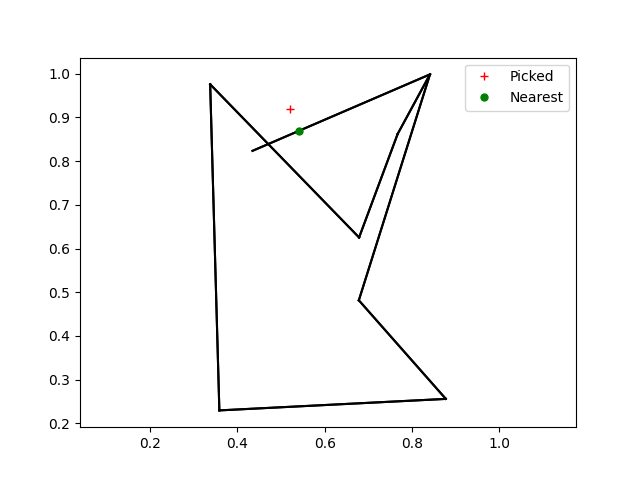

In [20]:
%matplotlib widget
fig, ax = plt.subplots()
graph = generate_random_graph()
graph.plot(ax)
picked_pt =  np.random.rand(2) 
nearest_pt, _, _ = closest_point_on_graph(graph, picked_pt)
pickedline, = ax.plot(picked_pt[0], picked_pt[1], 'r+', label='Picked')
nearestlines, = ax.plot(nearest_pt[0], nearest_pt[1], 'go', markersize=5, label='Nearest')
ax.legend()

# # useful for debuging
# # Create a textarea to display the interactive message
# txtwidget = widgets.Textarea(
#     value='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     placeholder='Picked: (000.0, 000.0); Nearest: (000.0, 000.0)',
#     description='',
#     disabled=True
# )
# display(txtwidget)

def onclick_nearest(event):
    pickedline.set_xdata([event.xdata])
    pickedline.set_ydata([event.ydata])
    picked_pt = np.array([event.xdata, event.ydata])
    nearest_pt, _, _ = closest_point_on_graph(graph, picked_pt)
    # txtwidget.value = str(nearest_pt)
    nearestlines.set_xdata([nearest_pt[0]])
    nearestlines.set_ydata([nearest_pt[1]])
    
fig.canvas.mpl_connect('button_release_event', onclick_nearest)    


In [21]:
def expand_graph(graph, pt):
    nearest_pt, dist, nearest_pt_verts = closest_point_on_graph(graph, pt)
    if len(nearest_pt_verts) == 2:
        vs, ve = nearest_pt_verts
        npt_vert = graph.add_vertex(nearest_pt)
        print(npt_vert.coord)
        graph.add_edge(vs, npt_vert)
        graph.add_edge(npt_vert, ve)
    elif len(nearest_pt_verts) == 1:
        npt_vert = nearest_pt_verts[0]
    else:
        raise ValueError("Invalid nearest_pt_vids")
    
    fid = graph.add_vertex(pt)
    print(fid.coord)
    graph.add_edge(npt_vert, fid)

[0.14929819 0.65579839]
[0.06691787 0.57731687]


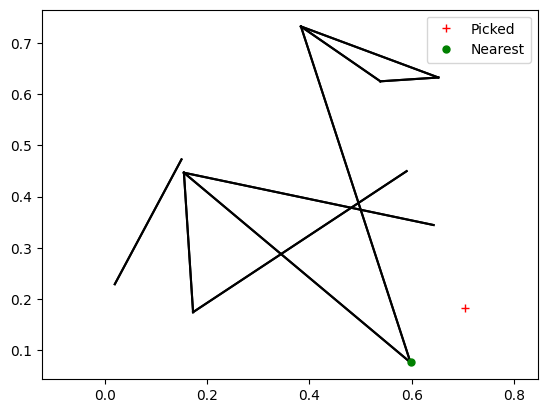

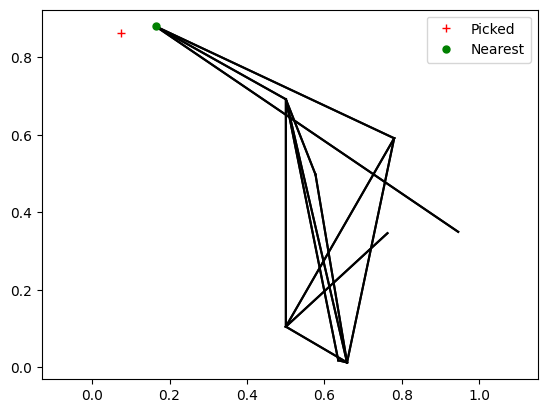

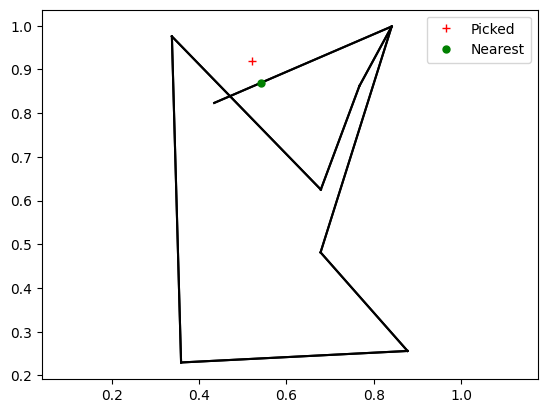

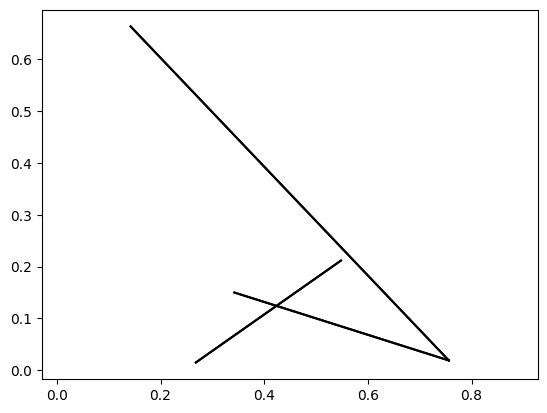

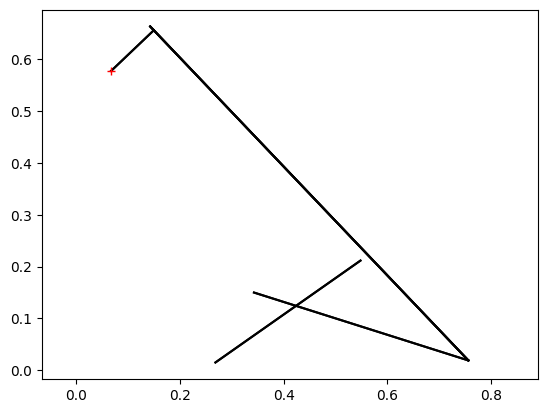

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
graph = generate_random_graph()
graph.plot(ax)

fig, ax = plt.subplots()
picked_pt = np.random.rand(2)
expand_graph(graph, picked_pt)
graph.plot(ax)
pickedline, = ax.plot(picked_pt[0], picked_pt[1], 'r+', label='Picked')


15

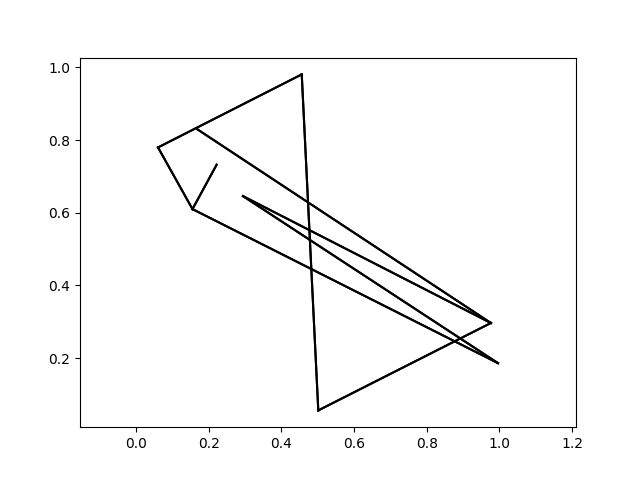

In [23]:
%matplotlib widget
fig, ax = plt.subplots()
graph = generate_random_graph()
graph.plot(ax)

def onclick_nearest(event):
    picked_pt = np.array([event.xdata, event.ydata])
    expand_graph(graph, picked_pt)
    ax.clear()
    graph.plot(ax)
    pickedline, = ax.plot(picked_pt[0], picked_pt[1], 'r+', label='Picked')
    ax.legend()
    
fig.canvas.mpl_connect('button_release_event', onclick_nearest)

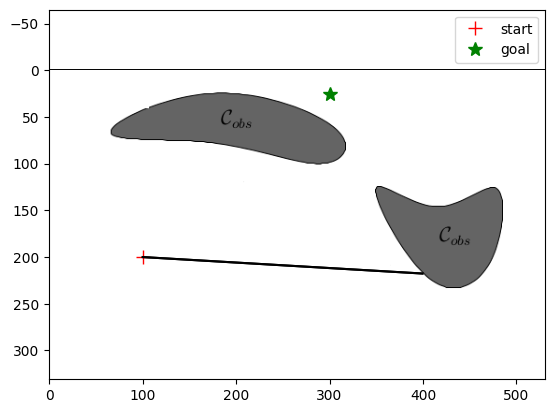

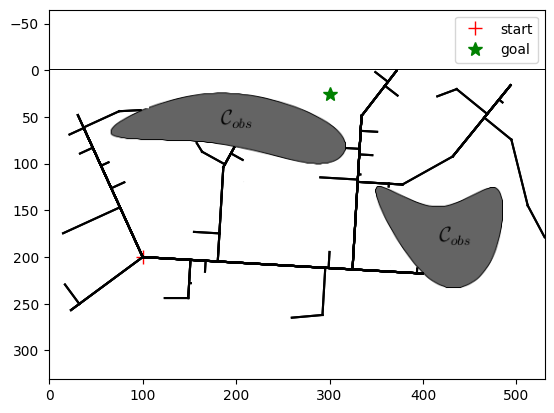

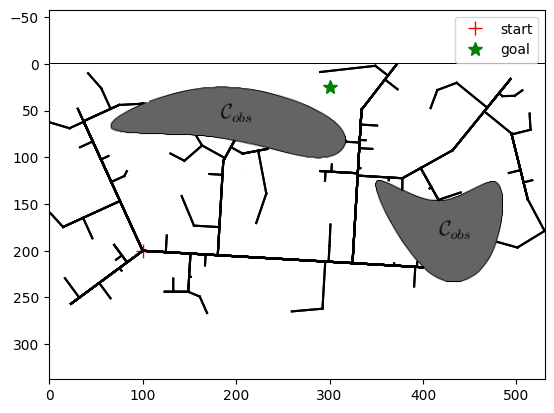

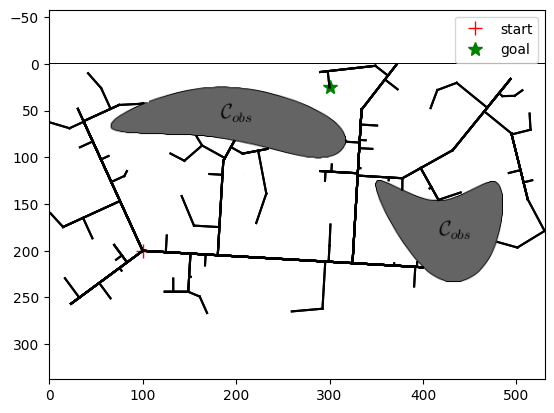

In [29]:
%matplotlib inline
# Need img as the map representation
assert img is not None

Npts = 101 # we are going to sample 100 points, but start with 1 point
# Specify the bounds of the map
pt_min = np.array([0, 0])
pt_max = np.array([img.shape[1], img.shape[0]])

stepsize = 1


# 1. Initialize an empty graph with the start point
graph = Graph()
graph.add_vertex(start)

# 2. While not done
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

    # 2.B Connect the sampled point to the nearest point (vertex or edge) 
    # on the graph, as long as the connecting line does not pass through the obstacle.
    
    nearest_pt, dist, nearest_pt_vids = closest_point_on_graph(graph, random_pt)
    steps = int(np.floor(dist / stepsize))
    if steps <= 0:
        continue
    direction = (random_pt - nearest_pt) / np.linalg.norm(random_pt - nearest_pt)
    all_points = np.arange(1, steps + 1)[:, None]*stepsize*direction+ nearest_pt[None, :]
    collisions = do_points_collide(img, all_points)
    if collisions[0]:
        continue
    indices, = np.nonzero(collisions)
    first_non_colliding = all_points[indices[0]-1] if len(indices)  else random_pt
    if len(nearest_pt_vids) == 2:
        vs, ve = nearest_pt_vids
        npt_vid = graph.add_vertex(nearest_pt)
        graph.add_edge(vs, npt_vid)
        graph.add_edge(npt_vid, ve)
    elif len(nearest_pt_vids) == 1:
        npt_vid = nearest_pt_vids[0]
    else:
        raise ValueError("Invalid nearest_pt_vids")
    fid = graph.add_vertex(first_non_colliding)
    graph.add_edge(npt_vid, fid)
    if i % 50 == 0:
        fig, ax = plt.subplots()
        plot_map(ax, img, goal, start)
        graph.plot(ax)
        plt.show()

for _ in range(1):
    random_pt = goal
    nearest_pt, dist, nearest_pt_vids = closest_point_on_graph(graph, random_pt)
    steps = int(np.floor(dist / stepsize))
    if steps <= 0:
        continue
    direction = (random_pt - nearest_pt) / np.linalg.norm(random_pt - nearest_pt)
    all_points = np.arange(1, steps + 1)[:, None]*stepsize*direction+ nearest_pt[None, :]
    collisions = do_points_collide(img, all_points)
    if collisions[0]:
        continue
    indices, = np.nonzero(collisions)
    first_non_colliding = all_points[indices[0]-1] if len(indices)  else random_pt
    if len(nearest_pt_vids) == 2:
        vs, ve = nearest_pt_vids
        npt_vid = graph.add_vertex(nearest_pt)
        graph.add_edge(vs, npt_vid)
        graph.add_edge(npt_vid, ve)
    elif len(nearest_pt_vids) == 1:
        npt_vid = nearest_pt_vids[0]
    else:
        raise ValueError("Invalid nearest_pt_vids")
    fid = graph.add_vertex(first_non_colliding)
    graph.add_edge(npt_vid, fid)

    fig, ax = plt.subplots()
    plot_map(ax, img, goal, start)
    graph.plot(ax)
    plt.show()